<a href="https://colab.research.google.com/github/SathvikCholleti/-Stock-Market-Volatility-Based-on-Time-Series-Data/blob/main/test_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import yfinance as yf


In [ ]:
# Load the data
history = yf.download('SBIN.NS', start='2000-01-01', end='2024-10-09', interval='1d')
history = history[['Open', 'Close', 'Volume']]
history['prev_close'] = history['Close'].shift(2)
history['prev_volume'] = history['Volume'].shift(2)
history.dropna(inplace=True)
 # Drop rows with NaN values


[*********************100%***********************]  1 of 1 completed
<ipython-input-4-cdbe1e75e880>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history['prev_close'] = history['Close'].shift(2)
<ipython-input-4-cdbe1e75e880>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history['prev_volume'] = history['Volume'].shift(2)
<ipython-input-4-cdbe1e75e880>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

In [ ]:
# Features and target variable
y = history['prev_close'].values
X = history.drop(['Close', 'Volume'], axis=1).values


In [ ]:
# Split data into training+validation and test sets (80% training+validation, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Split training+validation into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, shuffle=False)

print(f"x_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


x_train shape: (3946, 3), y_train shape: (3946,)
x_val shape: (987, 3), y_val shape: (987,)
x_test shape: (1234, 3), y_test shape: (1234,)


In [ ]:
# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
y_train = scaler.fit_transform(y_train.reshape(-1, 1))
y_val = scaler.transform(y_val.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1))


In [ ]:
# Prepare the data for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

time_step = 10  # Number of previous time steps to use
X_train, y_train = create_dataset(y_train, time_step)
X_val, y_val = create_dataset(y_val, time_step)
X_test, y_test = create_dataset(y_test, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
# Build LSTM model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))  # Input layer
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0315 - val_loss: 0.0012
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.7235e-04 - val_loss: 0.0012
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.5082e-04 - val_loss: 0.0014
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.5452e-04 - val_loss: 0.0011
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.7996e-04 - val_loss: 0.0012
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.2829e-04 - val_loss: 0.0011
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.2010e-04 - val_loss: 0.0015
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.0334e-04 - val_loss: 9.9103e-04
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.8696e-04 - val_loss: 9.4753e-04
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7568e-04 - val_loss: 9.2071e-04
Epoch 11/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4033e-04 - val_loss: 0.0

In [ ]:
# Predict on the test set
y_test_pred = model.predict(X_test)

# Inverse transform predictions
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test_actual = scaler.inverse_transform(y_test)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [ ]:
# Evaluate
rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
print(f'LSTM - RMSE: {rmse}')


LSTM - RMSE: 23.418655231806888


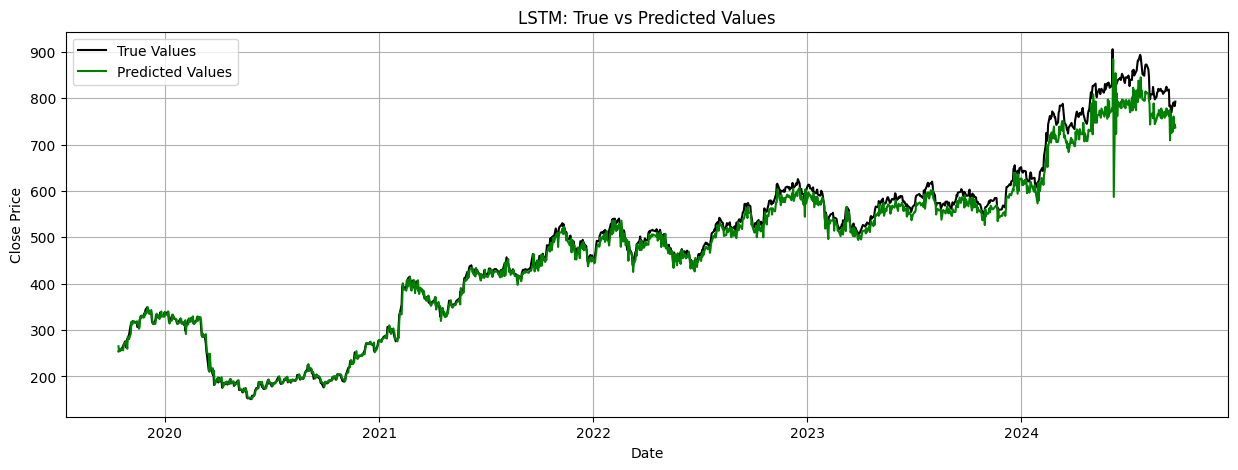

In [ ]:
# Plot results
plt.figure(figsize=(15, 5))
plt.plot(history.index[-len(y_test_actual):], y_test_actual, 'black', label='True Values')
plt.plot(history.index[-len(y_test_pred):], y_test_pred, 'green', label='Predicted Values')
plt.title('LSTM: True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Get the last 'time_step' number of data points from the test set
last_sequence = y_test[-time_step:]  # Last 'time_step' values
last_sequence_scaled = scaler.transform(last_sequence.reshape(-1, 1))  # Scale the last sequence

# Prepare the input for the model
next_day_input = last_sequence_scaled.reshape((1, time_step, 1))


In [ ]:
# Make prediction for the next day
next_day_prediction = model.predict(next_day_input)

# Inverse transform the prediction to get the actual price
next_day_prediction_actual = scaler.inverse_transform(next_day_prediction)
print(f'Next Day Prediction: {next_day_prediction_actual[0][0]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Next Day Prediction: 2.3889472484588623


In [ ]:
# Create a list to hold predictions
next_week_predictions = []
next_month_predictions = []

# Use the last sequence for predictions
current_sequence = y_test[-time_step:]

# Predict for the next week (7 days)
for _ in range(7):
    # Prepare the input for the model
    current_sequence_scaled = scaler.transform(current_sequence.reshape(-1, 1))
    next_input = current_sequence_scaled.reshape((1, time_step, 1))

    # Make prediction
    next_day_prediction = model.predict(next_input)

    # Inverse transform the prediction
    next_day_prediction_actual = scaler.inverse_transform(next_day_prediction)

    # Store the prediction
    next_week_predictions.append(next_day_prediction_actual[0][0])

    # Update the current_sequence for the next prediction
    current_sequence = np.append(current_sequence[1:], next_day_prediction_actual)

# Reset current_sequence for next month predictions
current_sequence = y_test[-time_step:]

# Predict for the next month (30 days)
for _ in range(30):
    current_sequence_scaled = scaler.transform(current_sequence.reshape(-1, 1))
    next_input = current_sequence_scaled.reshape((1, time_step, 1))

    next_day_prediction = model.predict(next_input)
    next_day_prediction_actual = scaler.inverse_transform(next_day_prediction)

    next_month_predictions.append(next_day_prediction_actual[0][0])

    current_sequence = np.append(current_sequence[1:], next_day_prediction_actual)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

In [ ]:
print("Next Week Predictions:")
print(next_week_predictions)

print("\nNext Month Predictions:")
print(next_month_predictions)


Next Week Predictions:
[2.3889472, 2.4059613, 2.4243646, 2.4426522, 2.460795, 2.4790385, 2.49695]

Next Month Predictions:
[2.3889472, 2.4059613, 2.4243646, 2.4426522, 2.460795, 2.4790385, 2.49695, 2.514768, 2.5326622, 2.5506573, 2.5685983, 2.5864875, 2.6043572, 2.6222098, 2.640028, 2.6578288, 2.6755953, 2.693342, 2.7110617, 2.7287593, 2.7464347, 2.7640808, 2.7817047, 2.7993038, 2.8168786, 2.8344285, 2.8519566, 2.8694599, 2.8869436, 2.904393]


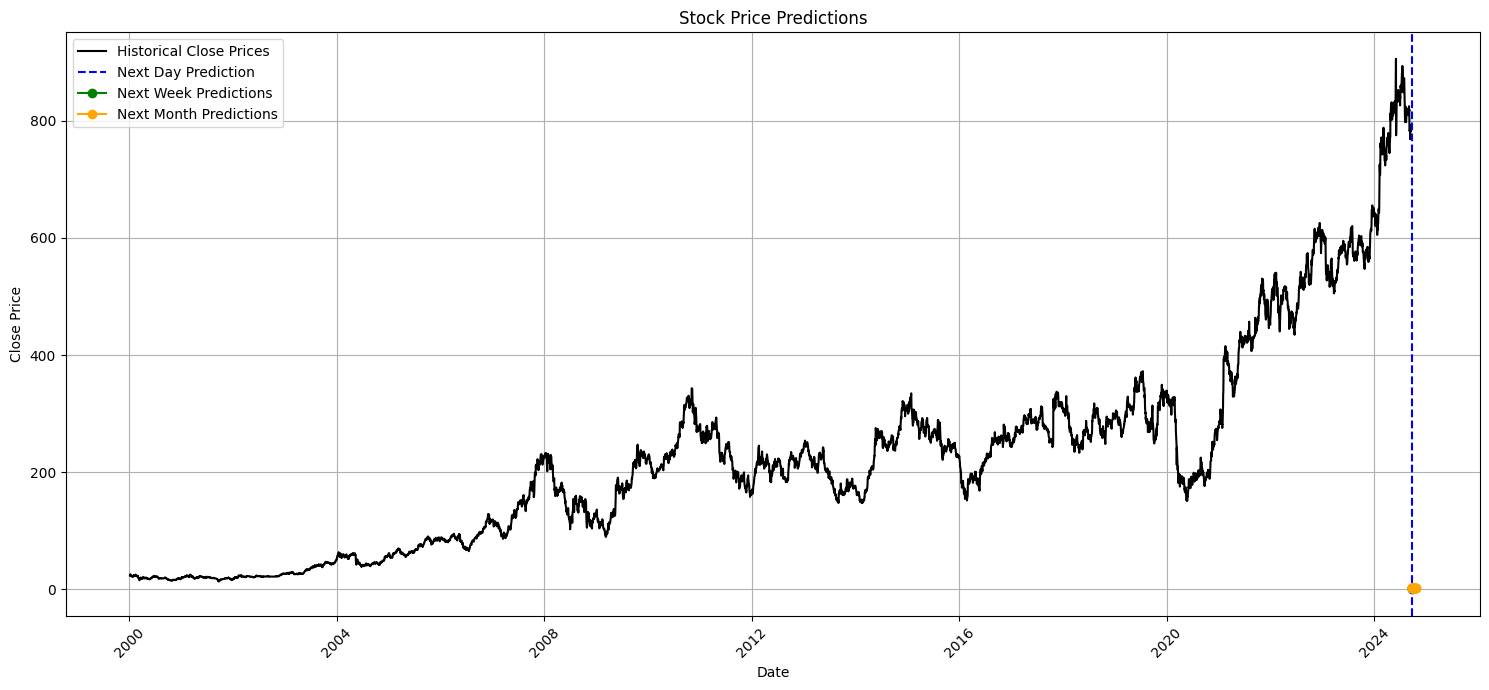

In [ ]:
from datetime import timedelta

# Prepare dates for plotting
last_date = history.index[-1]
next_week_dates = [last_date + timedelta(days=i) for i in range(1, 8)]
next_month_dates = [last_date + timedelta(days=i) for i in range(1, 31)]

# Create a combined plot
plt.figure(figsize=(15, 7))

# Plot historical data
plt.plot(history.index, history['Close'], color='black', label='Historical Close Prices')

# Plot next day prediction (last available prediction)
plt.axvline(x=last_date + timedelta(days=1), color='blue', linestyle='--', label='Next Day Prediction')
plt.scatter([last_date + timedelta(days=1)], [next_day_prediction], color='blue')

# Plot next week predictions
plt.plot(next_week_dates, next_week_predictions, color='green', marker='o', label='Next Week Predictions')

# Plot next month predictions
plt.plot(next_month_dates, next_month_predictions, color='orange', marker='o', label='Next Month Predictions')

# Customize the plot
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Train the model and save the training history
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))



Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5856e-04 - val_loss: 3.3362e-04
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3244e-04 - val_loss: 3.1905e-04
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3053e-04 - val_loss: 3.1493e-04
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3411e-04 - val_loss: 3.8082e-04
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3702e-04 - val_loss: 3.7492e-04
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.3086e-04 - val_loss: 3.0866e-04
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.2658e-04 - val_loss: 3.0717e-04
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3071e-04 - val_loss: 3.1494e-04
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2889e-04 - val_loss: 3.3739e-04
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6183e-04 - val_loss: 3.6142e-04
Epoch 11/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step -

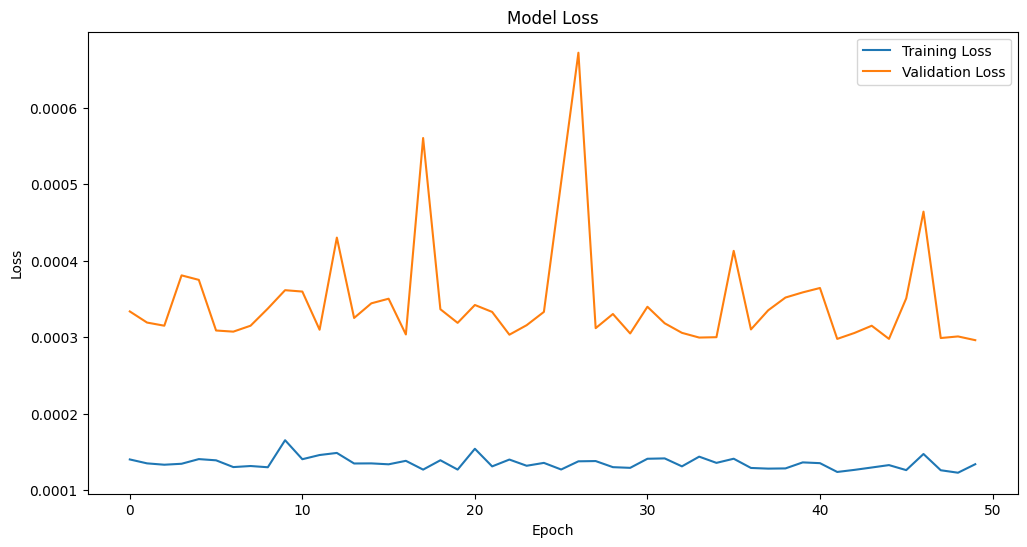

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
import yfinance as yf

# Re-download the stock data
history = yf.download('SBIN.NS', start='2000-01-01', end='2024-09-09', interval='1d')
history = history.loc[:, ['Open', 'Close', 'Volume']]
history['prev_close'] = history['Close'].shift(2)
history['prev_volume'] = history['Volume'].shift(2)

# Calculate other features as before...
# Add your feature calculations here...

# Display the DataFrame to ensure it's correct
display(history)

# Drop rows with NaN values
history = history.dropna()


[*********************100%***********************]  1 of 1 completed


,Open,Close,Volume,prev_close,prev_volume
Date,,,,,
2000-01-03,22.267092,22.988886,25152894,NaN,NaN
2000-01-04,22.988886,24.446625,47648560,NaN,NaN
2000-01-05,23.493668,23.441774,36396207,22.988886,25152894.0
2000-01-06,23.776726,24.625893,70573968,24.446625,47648560.0
2000-01-07,24.673071,25.786425,83453217,23.441774,36396207.0
...,...,...,...,...,...
2024-09-02,817.299988,822.150024,11813750,814.500000,18247268.0
2024-09-03,822.150024,824.799988,10548350,815.599976,8911426.0
2024-09-04,815.450012,816.500000,10789570,822.150024,11813750.0


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Prepare data for the Random Forest model
y = history['Close'].values
X = history.drop(['Close', 'Volume'], axis=1).values

# Split data into training+validation and test sets (80% training+validation, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Split training+validation into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, shuffle=False)

# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on validation and test sets
y_val_pred = rf_model.predict(X_val)
y_test_pred = rf_model.predict(X_test)

# Evaluate
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Random Forest - Validation RMSE: {val_rmse}')
print(f'Random Forest - Test RMSE: {test_rmse}')


Random Forest - Validation RMSE: 8.771737291311226
Random Forest - Test RMSE: 220.55100349603677
